## Title: A practical guide to generating and interpreting visualizations of shotgun proteomics data

#### Authors:
#### Pre-print:
#### Revision:

In [ ]:
# Install all packages directly in the notebook
#!pip install pythonnet numpy pandas numba tqdm plotly

In [1]:
# import all necessary libraries
import logging
import pandas as pd
import numpy as np
from numba import njit
from tqdm import tqdm
from pyrawfilereader import RawFileReader

import plotly.graph_objects as go

# specify a configuration whether to display the Plotly logo in the toolbar and how to save the plot
config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 500,
        'width': 700,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
      }
}

The raw file is used from the [Project PXD010697 from ProteomeXchange](https://www.ebi.ac.uk/pride/archive/projects/PXD010697).

In [2]:
# specify a path to the Thermo .raw file
# TODO: add an option to download the file authomatically?
sample_path = "D:/vis_review/Data/PXD010697_circadian_clock/20170123_Qep6_ChRo_SA_collab_SYN_CT_phospho_1.raw"

In [3]:
# Necessary functions to read Thermo Raw file

def load_thermo_raw(
    raw_file,
    most_abundant=1000
):
    """
    Load a Thermo raw file and extract all spectra
    """

    rawfile = RawFileReader(raw_file)

    spec_indices = np.array(
        range(rawfile.FirstSpectrumNumber, rawfile.LastSpectrumNumber + 1)
    )

    scan_list = []
    rt_list = []
    mass_list = []
    int_list = []
    ms_list = []
    prec_mzs_list = []
    mono_mzs_list = []
    charge_list = []

    for i in tqdm((spec_indices)):
        try:
            ms_order = rawfile.GetMSOrderForScanNum(i)
            rt = rawfile.RTFromScanNum(i)
            

            if ms_order == 2:
                prec_mz = rawfile.GetPrecursorMassForScanNum(i, 0)

                mono_mz, charge = rawfile.GetMS2MonoMzAndChargeFromScanNum(i)
            else:
                prec_mz, mono_mz, charge = 0,0,0

            masses, intensity = rawfile.GetCentroidMassListFromScanNum(i)
            if ms_order == 2:
                masses, intensity = get_most_abundant(masses, intensity, most_abundant)

            scan_list.append(i)
            rt_list.append(rt)
            mass_list.append(np.array(masses))
            int_list.append(np.array(intensity, dtype=np.int64))
            ms_list.append(ms_order)
            prec_mzs_list.append(prec_mz)
            mono_mzs_list.append(mono_mz)
            charge_list.append(charge)
        except KeyboardInterrupt as e:
            raise e
        except SystemExit as e:
            raise e
        except Exception as e:
            logging.info(f"Bad scan={i} in raw file '{raw_file}'")

    scan_list_ms1 = [scan_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    rt_list_ms1 = [rt_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    mass_list_ms1 = [mass_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    int_list_ms1 = [int_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    ms_list_ms1 = [ms_list[i] for i, _ in enumerate(ms_list) if _ == 1]

    scan_list_ms2 = [scan_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    rt_list_ms2 = [rt_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    mass_list_ms2 = [mass_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    int_list_ms2 = [int_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    ms_list_ms2 = [ms_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    mono_mzs2 = [mono_mzs_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    charge2 = [charge_list[i] for i, _ in enumerate(ms_list) if _ == 2]

    prec_mass_list2 = [
        calculate_mass(mono_mzs_list[i], charge_list[i])
        for i, _ in enumerate(ms_list)
        if _ == 2
    ]

    check_sanity(mass_list)

    data = {}
#     data['scan_list'] = np.array(scan_list)
#     data["rt_list"] = np.array(rt_list)
#     data['ms_list'] = np.array(ms_list)
#     data['int_list'] = np.array(int_list)
    
    data["scan_list_ms1"] = np.array(scan_list_ms1)
    data["rt_list_ms1"] = np.array(rt_list_ms1)
    data["mass_list_ms1"] = np.array(mass_list_ms1, dtype=object)
    data["int_list_ms1"] = np.array(int_list_ms1, dtype=object)
    data["ms_list_ms1"] = np.array(ms_list_ms1)

    data["scan_list_ms2"] = np.array(scan_list_ms2)
    data["rt_list_ms2"] = np.array(rt_list_ms2)
    data["mass_list_ms2"] = mass_list_ms2
    data["int_list_ms2"] = int_list_ms2
    data["ms_list_ms2"] = np.array(ms_list_ms2)
    data["prec_mass_list2"] = np.array(prec_mass_list2)
    data["mono_mzs2"] = np.array(mono_mzs2)
    data["charge_ms2"] = np.array(charge2)

    rawfile.Close()
    return data

def get_most_abundant(
    mass, 
    intensity, 
    n_max
):
    """
    Returns the n_max most abundant peaks of a spectrum.
    Setting `n_max` to -1 returns all peaks.
    """
    if n_max == -1:
        return mass, intensity
    if len(mass) < n_max:
        return mass, intensity
    else:
        sortindex = np.argsort(intensity)[::-1][:n_max]
        sortindex.sort()

    return mass[sortindex], intensity[sortindex]

@njit
def calculate_mass(
    mono_mz, 
    charge
):
    """
    Calculate the precursor mass from mono mz and charge
    """
    M_PROTON = 1.00727646687
    prec_mass = mono_mz * abs(charge) - charge * M_PROTON

    return prec_mass

def check_sanity(
    mass_list
):
    """
    Sanity check for mass list to make sure the masses are sorted
    """
    if not all(
        mass_list[0][i] <= mass_list[0][i + 1] for i in range(len(mass_list[0]) - 1)
    ):
        raise ValueError("Masses are not sorted.")

In [4]:
# upload the thermo raw file
data = load_thermo_raw(sample_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54493/54493 [01:41<00:00, 538.21it/s]


In [ ]:
# df = pd.DataFrame({'scan': data['scan_list'], 
#                     'RT': data['rt_list'],
#                    'intensity': data['int_list'],
#                     'order': data['ms_list'],})

In [5]:
# save ms1 and ms2 data separately 
df_ms1 = pd.DataFrame({'scan': data['scan_list_ms1'], 
                    'RT': data['rt_list_ms1'],
                   'intensity': data['int_list_ms1'],
                    'order': 'ms1'})
df_ms2 = pd.DataFrame({'scan': data['scan_list_ms2'], 
                    'RT': data['rt_list_ms2'],
                   'intensity': data['int_list_ms2'],
                    'order': 'ms2'})

In [6]:
# combine two dataframes
df = pd.concat([df_ms1, df_ms2])
df.sort_values('RT', inplace=True)

In [7]:
# calculate summed and max intensity per each scan
df['summed_intensity'] = df.intensity.apply(lambda x: sum(x))
df['max_intensity'] = df.intensity.apply(lambda x: max(x))

In [ ]:
# df[df.scan == 31068]
# df.loc[df.scan == 31066, 'intensity'].values[0].sum()

In [11]:
def plot_tic(
    df, 
    title, 
    width=900,
    height=500
):
    """Create a total ion chromatogram (TIC) and Base Peak chromatogram (BPI) for the MS1 data.

    Parameters
    ----------
    df : pandas Dataframe
        A table with the extracted MS1 data.
    title : str
        The title of the plot.
        Default is False
    width : int
        The width of the plot.
        Default is 1000.
    height : int
        The height of the plot.
        Default is 320.

    Returns
    -------
    a Plotly line plot
        The line plot containing TIC and BPI for MS1 data of the provided dataset.
    """
    fig = go.Figure()
    
    total_ion_col = ['RT', 'summed_intensity']
    base_peak_col = ['RT', 'max_intensity']
    
    for chrom_type in ['TIC MS1', 'BPI MS1']:
        if chrom_type == 'TIC MS1':
            data = df[total_ion_col]
        elif chrom_type == 'BPI MS1':
            data = df[base_peak_col]
        fig.add_trace(
            go.Scatter(
                x=data.iloc[:, 0],
                y=data.iloc[:, 1],
                name=chrom_type,
                hovertemplate='<b>RT:</b> %{x};<br><b>Intensity:</b> %{y}.',
            )
        )
    
    fig.update_layout(
        title=dict(
            text=title,
            font=dict(
                size=16,
            ),
            x=0.5,
            xanchor='center',
            yanchor='top'
        ),
        xaxis=dict(
            title='RT, min',
            titlefont_size=14,
            tickmode = 'auto',
            tickfont_size=14,
        ),
        yaxis=dict(
            title='Intensity',
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        legend_title_text='Select:',
        hovermode="x",
        template="plotly_white",
        width=width,
        height=height
    )

    fig.update_xaxes(range=[0, df.RT.max()])
    return fig
    

## Figure 1 A/B

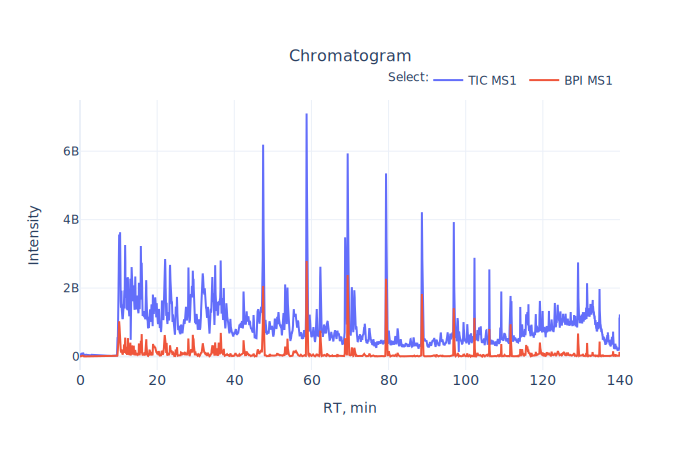

In [16]:
plot_tic(df[df.order == 'ms1'], 'Chromatogram').show('svg', config=config)